### **Implementação dos Controladores Proporcional e Proporcional Integral para o sitema Motor/Gerador**

Laboratório de controle - 2023.2\
Turma: T03

Coordenador: Cleison Silva

<br>

Grupo 4:

Andrez Muller Miranda Barreto\
Matrícula: 201833940007

Oséias Dias de Farias\
Matrícula: 201733940002

Thalia Damasceno Barroso\
Matrícula: 201633940040

Hebert Barroso\
Matrícula: 201733940007

<br>

---

# **Revisão Teórica**


# Controlador Proporcional
Função de transferência do controlador, 

$$G_c (s) = \frac{U(s)}{E(s)} = K_p $$

Logo o sinal de controle é proporcional ao erro de controle.

No domínio de tempo discreto, temos, 

$$ u(k) = K_p e(k)$$

Lembre-se de que o controlador foi projetado para um ponto de operação, logo para calcular o erro de contorle, deve remover o valor correspondente ao ponto de operação na saída, 

$y(k)$ = sinal_medido - valor_ponto_operação
$$e(k) = r(k) - y(k)$$




### **Implementação do Controlador P e gravação os dados dos sinais do sistema**

```python

"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

# gerenciador de dispositivo - encontrar porta COM
# from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt            # noqa: F401
import time as t
from scipy.signal import square, sawtooth  # noqa: F401
import serial
##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15; numAmostras = 400
tempo = np.zeros(numAmostras); y = np.zeros(numAmostras)

Ts = 0.02; fre = 0.5; Amplitude = 0.5; ponto_de_operacao = 0
nivel_dc_saida = 2.266; r = np.zeros(numAmostras)
u = np.zeros(numAmostras); toc = np.zeros(numAmostras)
# #####################

for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts)
print('\nEstabelecendo conexão.')
# Linux: port='/dev/ttyACM0'
conexao = serial.Serial(port='COM8', baudrate=9600, timeout=0.005)
t.sleep(1)
print('\nIniciando coleta.')

# #_____________ Loop principal de controle _____________##
nivel_dc_entrada = 7.5

# Ganho do Controlador Proporcional
# Kp = 2.296  # Valor de projeto
Kp = 5.5
for n in range(numAmostras):
    tic = t.time()
    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()
    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    # calcula o erro
    e = r[n] - sinal_medido
    # primeiras 50 amostras
    if (n < 50):
        u[n] = nivel_dc_entrada
        r[n] = 0.0
    else:
        u[n] = (Kp*e) + nivel_dc_entrada

    if (u[n] > amplitude_maxima):
        sinal_PWM = 255
    else:
        sinal_PWM = ((u[n])*255)/amplitude_maxima
    # sinal_PWM deve ser um número inteiro entre 0 e 255
    conexao.write(str(round(sinal_PWM)).encode())
    t.sleep(Ts)
    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic
conexao.write('0'.encode())
print('\nFim da coleta.')
conexao.close()

print('media=', np.mean(r))
print('\nPeríodo real:', np.mean(toc))
print('Nivel_DC:', np.mean(y[tempo > 2]))

dados = np.stack((tempo, r, y, u, r_ofessert), axis=-1)
np.savetxt("controle_P_dados_motorgerador.csv", dados, delimiter=";")

```

**Importando Bibliotecas usadas**

In [54]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy.signal as sg
from control.matlab import *
import scienceplots

%config InlineBackend.figure_format='retina'
plt.style.use(["science", "notebook"])

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Dados em Malha Aberta

In [55]:
dados_malha_aberta = pd.read_csv("dados/50pc_dados_motorgerador.csv",
                                 header = None, sep=';').values
dados_malha_aberta

array([[0.  , 8.5 , 0.  ],
       [0.02, 8.5 , 0.  ],
       [0.04, 8.5 , 0.  ],
       ...,
       [7.94, 6.5 , 2.11],
       [7.96, 6.5 , 2.1 ],
       [7.98, 6.5 , 2.11]])

### Sinais de Entrada e Saída - Sistema em Malha Aberta


Periodo de Amostragem: 0.02


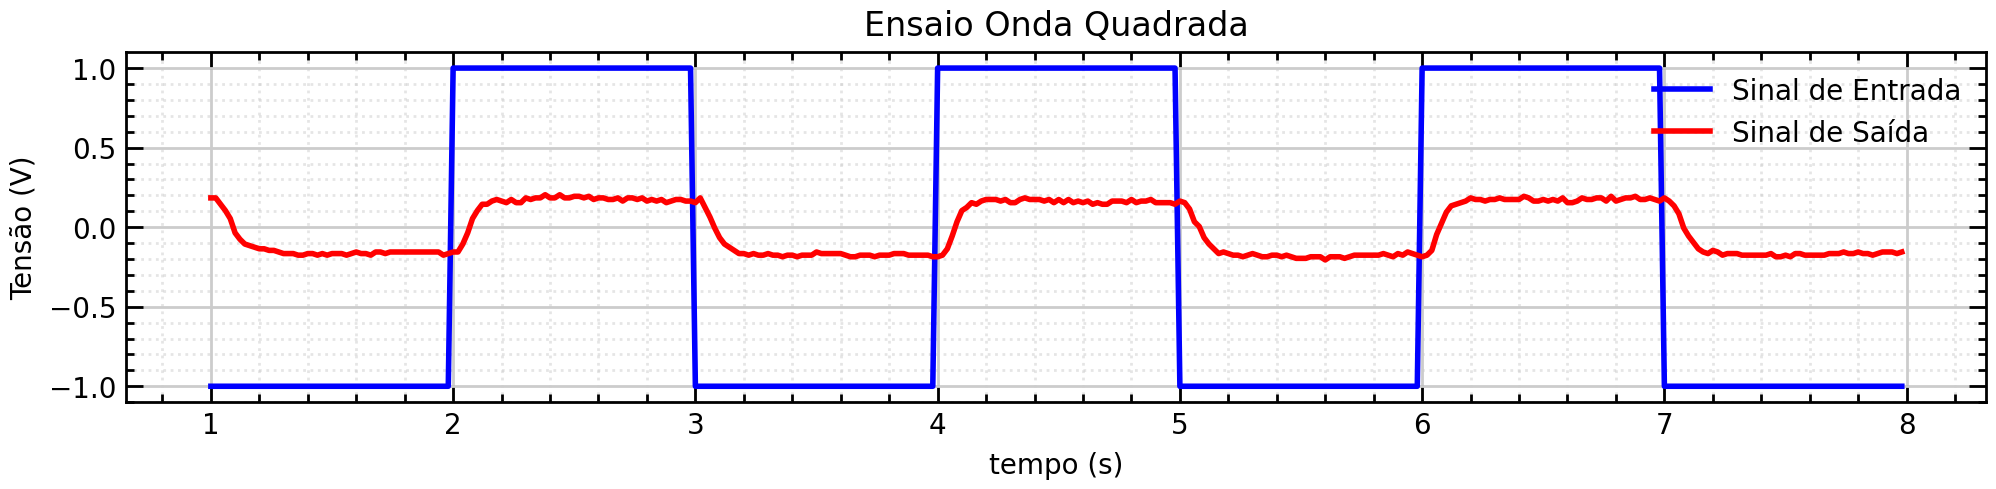

In [56]:
# Dados
tempo = np.array(dados_malha_aberta[:,0])
sinal_entrada  = np.array(dados_malha_aberta[:,1])
sinal_saida = np.array(dados_malha_aberta[:,2])

Ts = 0.02
print('\nPeriodo de Amostragem:', Ts)


plt.figure(figsize=(12, 5))
plt.subplot(211)
plt.plot(tempo[50:], sinal_entrada[50:] - 7.5, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo[50:], sinal_saida[50:] - 2.266, c = 'r', label = "Sinal de Saída")

plt. title('Ensaio Onda Quadrada', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=10)

plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.show()

### Dados em Malha Fechada Controlador Proporcional

In [57]:
#___________Código para Calcular o Kp ___________#
Km = 0.18666; tau = 0.090833

perc = 7/10
Kp = (1/perc - 1)/Km
print("\nGanho Proporcional: ", Kp)

Ganho = (Km*Kp)/(1+Kp*Km)
print("Ganho DC: ", Ganho)


Ganho Proporcional:  2.296000367360059
Ganho DC:  0.3


In [58]:
dados_malha_fechada_p = pd.read_csv("dados/controle_P_dados_motorgerador.csv",
                                    header = None, sep=';').values
dados_malha_fechada_p

array([[ 0.   ,  0.   ,  0.   ,  7.5  ,  2.266],
       [ 0.02 ,  0.   ,  0.   ,  7.5  ,  2.266],
       [ 0.04 ,  0.   ,  0.05 ,  7.5  ,  2.266],
       ...,
       [ 7.94 , -0.5  ,  2.07 ,  5.828,  1.766],
       [ 7.96 , -0.5  ,  2.06 ,  5.883,  1.766],
       [ 7.98 , -0.5  ,  2.04 ,  5.993,  1.766]])

In [59]:
# Dados ensaio em malha fechada controlador proporcional
tempo_controle_p = np.array(dados_malha_fechada_p[:,0])
referencia_controlador_p  = np.array(dados_malha_fechada_p[:,1])
sinal_saida_controlador_p = np.array(dados_malha_fechada_p[:,2])
sinal_controle_controlador_p = np.array(dados_malha_fechada_p[:,3])
referencia_offeset_controlador_p = np.array(dados_malha_fechada_p[:,4])

### Simulação do sistema em malha fechada com controlador Proporcional

In [60]:
num = [Km]
den = [tau, 1.]
Gs = ct.tf(num, den)

# Ganho do Controlador testado na bancada
Kp = 5.5
Gc = Kp

# # ________Sistema em Malha Fechada __________##
H = ct.feedback(Gc*Gs, 1, sign = -1)
print("Sistema em Malha Fechada:\n", H)

# # ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##
_, y_malha_fechada = ct.forced_response(H, T=tempo_controle_p,
                                        U=referencia_controlador_p)

## ________Sistema para Obter Sinal de Controle __________##
C = ct.feedback(Gc, Gs, sign =-1)
print("Sinal de Controle:\n", C)

## ________Simulação para obter o Sinal de Controle __________##
_, sinal_controle = ct.forced_response(C, T=tempo_controle_p, U=referencia_controlador_p)

Sistema em Malha Fechada:
 
      1.027
-----------------
0.09083 s + 2.027

Sinal de Controle:
 
 0.4996 s + 5.5
-----------------
0.09083 s + 2.027



### Comparação entre a simulação e o sistema real
Para fins de comparação e validação do controlador, foi realizado uma simulação em malha fechada e posteriormente um ensaio do sistema em malha fechada com o controlador proporcional projetado, dessa forma, ao comparar os valores pode-se chegar a uma comclusão com relação a eficácia do controlador.

O Controlador proporcional tem por característica diminuir o erro em regime permanente, porém sem zera-lo.

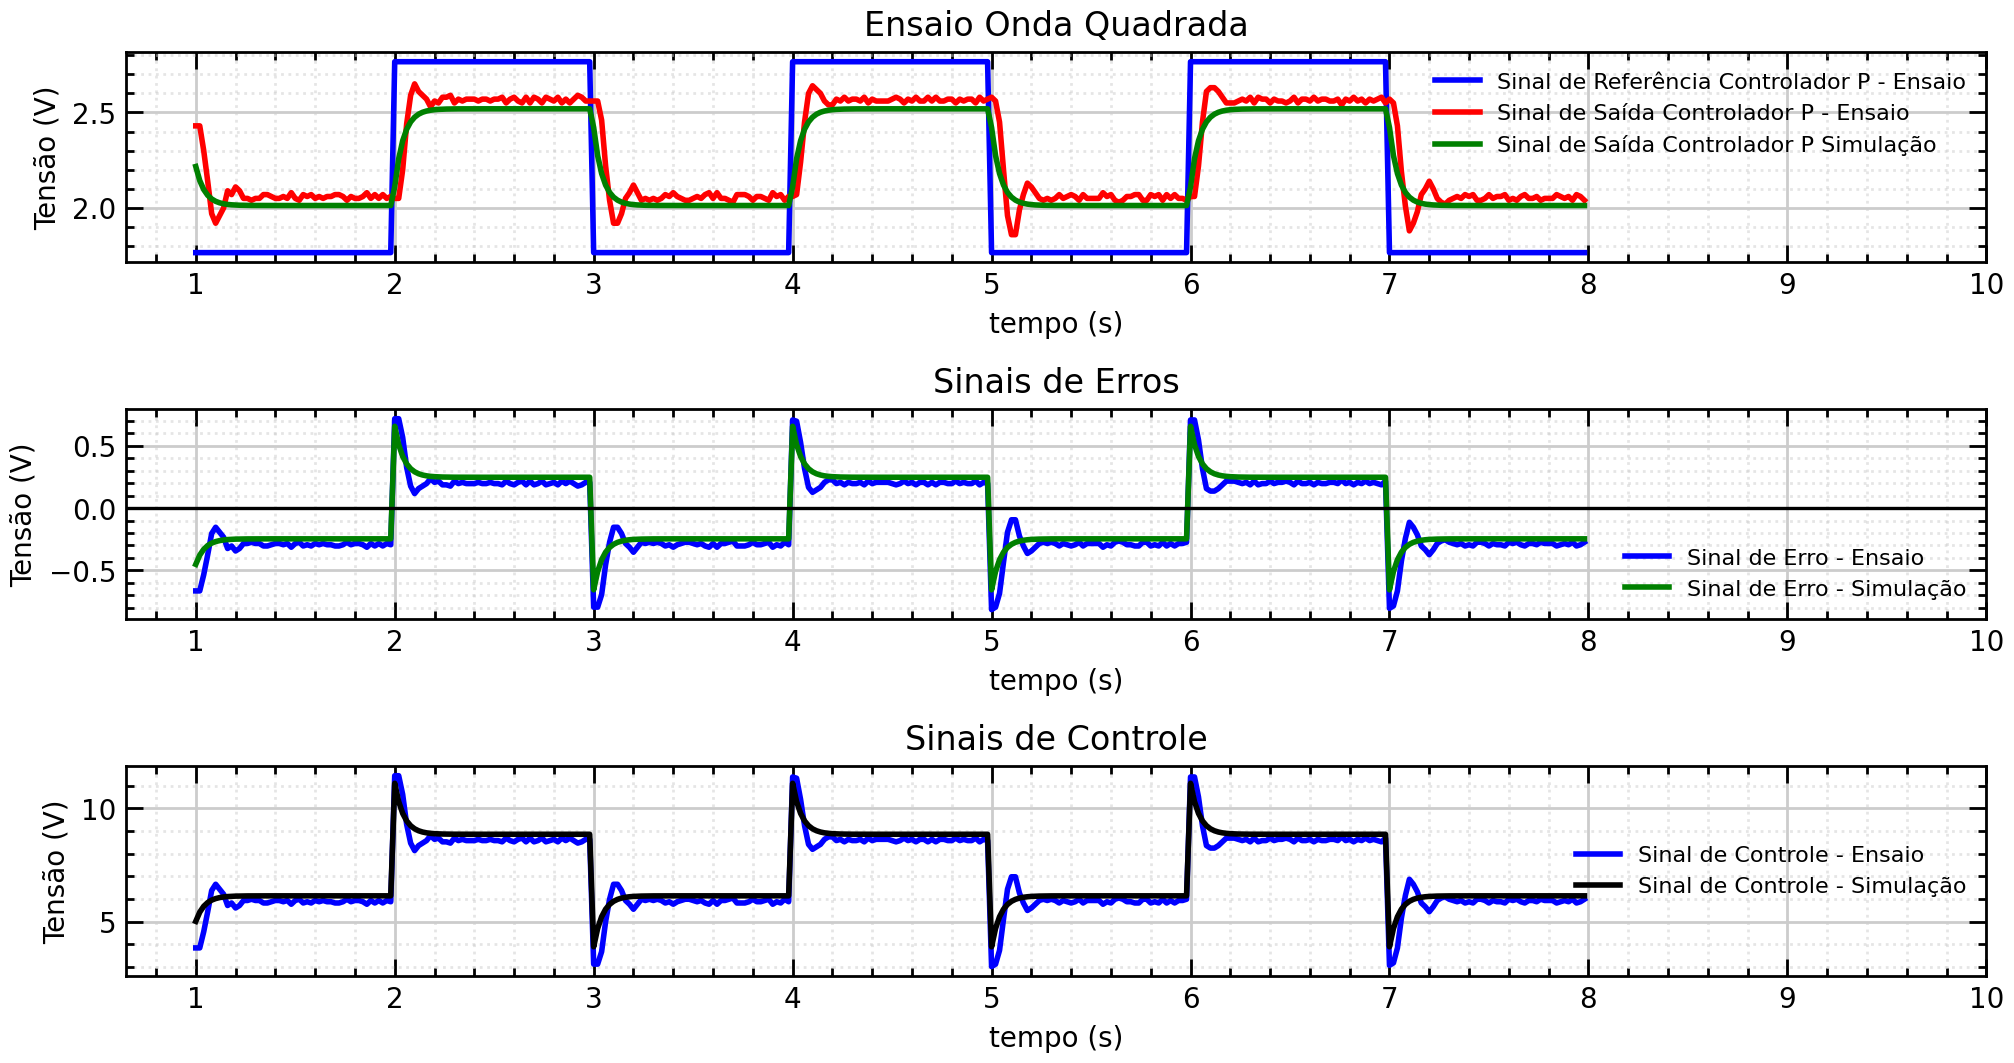

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(tempo_controle_p[50:], referencia_offeset_controlador_p[50:],
         c='b', label="Sinal de Referência Controlador P - Ensaio")
plt.plot(tempo_controle_p[50:], sinal_saida_controlador_p[50:],
         c='r', label= "Sinal de Saída Controlador P - Ensaio")
plt.plot(tempo_controle_p[50:], y_malha_fechada[50:] + 2.266,
         c='g', label="Sinal de Saída Controlador P Simulação")

plt.title('Ensaio Onda Quadrada', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8)
plt.xticks(range(1, 11))
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.subplot(312)
erro_ensaio_p = referencia_controlador_p[50:] - (sinal_saida_controlador_p[50:] - 2.266)
erro_simu_p = referencia_controlador_p[50:] - (y_malha_fechada[50:])
plt.plot(tempo_controle_p[50:], erro_ensaio_p,
         c = 'b', label = "Sinal de Erro - Ensaio")
plt.plot(tempo_controle_p[50:], erro_simu_p,
         c = 'g', label = "Sinal de Erro - Simulação")

plt.title('Sinais de Erros', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8, loc='lower right')
plt.xticks(range(1, 11))
plt.axhline(0, color='black', lw=1.2)
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.subplot(313)
plt.plot(tempo_controle_p[50:], sinal_controle_controlador_p[50:],
         c = 'b', label = "Sinal de Controle - Ensaio")
plt.plot(tempo_controle_p[50:], sinal_controle[50:] + 7.5,
         c = 'black', label = "Sinal de Controle - Simulação")

plt.title('Sinais de Controle', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8, loc='center right')
plt.xticks(range(1, 11))
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.subplots_adjust(hspace=0.7)
plt.show()

A partir das análises dos gráficos acima, é possível observar o comportamento do sinal de erro para o sistema em malha fechada com controlador P, e concluir que o cotrolador proporcional tem a capacidade de diminuir o erro de regime permanente, porém não é capaz de zera-lo, por outro lado, o sinal de saída se aproxima do sinal de referência.

Além disso, o sinal de controle tem as mesmas características do sinal de erro, no entando multiplicado por um ganho Kp.

<br>

---

# Controlador PI

Função de Transferência de Controlador PI:

$$ G_c (s) = \frac{K_c (s + a)}{s} \tag{B}$$

Discretização para $T_s$, período de amostragem. 

1. Forward Differences
$$G_c(z) = G_c(s)|_{s = \frac{z - 1}{T_s}}$$
2. Backwards Differences
$$G_c(z) = G_c(s)|_{s = \frac{1}{T_s} \frac{z - 1}{z}}$$
3. Trapezoidal (Tustin)
  $$G_c(z) = G_c(s)|_{s = \frac{2}{T_s} \frac{z - 1}{z + 1}}$$

No domínio $z$, temos, 
$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


no tempo discreto, a Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$ 


### **Implementação do Controlador PI e gravação os dados dos sinais do sistema**


```python

"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""
# gerenciador de dispositivo - encontrar porta COM
# from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt            # noqa: F401
import time as t
from scipy.signal import square, sawtooth  # noqa: F401
import serial

##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15; numAmostras = 400; tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras); e = np.zeros(numAmostras)

Ts = 0.02; fre = 0.5; Amplitude = 0.5

ponto_de_operacao = 0; nivel_dc_saida = 2.266
r = np.zeros(numAmostras); u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
# #####################
for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts)
print('\nEstabelecendo conexão.')
# port='/dev/ttyACM0'
conexao = serial.Serial(port='COM8', baudrate=9600, timeout=0.005)
t.sleep(1)
print('\nIniciando coleta.')

# _____________ Loop principal de controle _____________#
nivel_dc_entrada = 7.5

# Ganho do Controlador Proporcional
for n in range(numAmostras):
    tic = t.time()
    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()
    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    # calcula o erro
    e[n] = r[n] - sinal_medido
    # primeiras 50 amostras
    if (n < 50):
        u[n] = nivel_dc_entrada
        r[n] = 0.0
    else:
        u[n] = (u[n-1] + 2.404*e[n] - 1.331*e[n-1])
    if (u[n] > amplitude_maxima):
        sinal_PWM = 255
    else:
        sinal_PWM = ((u[n])*255)/amplitude_maxima
        sinal_PWM += 127
    # sinal_PWM deve ser um número inteiro entre 0 e 255
    conexao.write(str(round(sinal_PWM)).encode())
    t.sleep(Ts)

    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic

conexao.write('0'.encode())
print('\nFim da coleta.')
conexao.close()

print('media=', np.mean(r))
print('\nPeríodo real:', np.mean(toc))
print('Nivel_DC:', np.mean(y[tempo > 2]))

dados = np.stack((tempo, r, y, e, u, r_ofessert), axis=-1)
np.savetxt("controle_PI_dados_motorgerador.csv", dados, delimiter=";")

```

### Dados em Malha Fechada Controlador Proporcional

In [62]:
dados_malha_fechada_pi = pd.read_csv("dados/controle_PI_dados_motorgerador.csv",
                                    header = None, sep=';').values
dados_malha_fechada_pi

array([[ 0.      ,  0.      ,  0.      ,  2.766   ,  7.5     ,  2.266   ],
       [ 0.02    ,  0.      ,  0.      ,  2.766   ,  7.5     ,  2.266   ],
       [ 0.04    ,  0.      ,  0.06    ,  2.706   ,  7.5     ,  2.266   ],
       ...,
       [ 7.94    , -0.5     ,  1.78    , -0.014   , -2.534986,  1.766   ],
       [ 7.96    , -0.5     ,  1.79    , -0.024   , -2.574048,  1.766   ],
       [ 7.98    , -0.5     ,  1.78    , -0.014   , -2.57576 ,  1.766   ]])

In [63]:
# Dados ensaio em malha fechada controlador proporcional integral
tempo_controle_pi = np.array(dados_malha_fechada_pi[:,0])
referencia_controlador_pi  = np.array(dados_malha_fechada_pi[:,1])
sinal_saida_controlador_pi = np.array(dados_malha_fechada_pi[:,2])
sinal_erro_controlador_pi = np.array(dados_malha_fechada_pi[:,3])
sinal_controle_controlador_pi = np.array(dados_malha_fechada_pi[:,4])
referencia_offeset_controlador_pi = np.array(dados_malha_fechada_pi[:,5])

### Simulação do Sinal de Saída e de Controle

In [64]:
# Fator de Amortecimento
qsi = 0.707

# Freq Natural
wn = 10.5; b = 1/tau; K = Km

num = [Km]
den = [tau, 1.]
Gs = ct.tf(num, den)

Kc = (((2*qsi*wn)/b)-1)/K
a =  (wn**2)/(Kc*K*b)
print('Ganho do Controlador PI: \n', Kc, '\n Zero do PI: \n', a)

Gc = ct.tf([Kc*1, Kc*a], [1, 0])
H_pi = ct.feedback(Gc*Gs, 1, sign = -1)
C_pi = ct.feedback(Gc, Gs, sign = -1)

# # ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##
_, y_malha_fechada_pi = ct.forced_response(H_pi, T=tempo_controle_pi,
                                        U=referencia_controlador_pi)

## ________Sistema para Obter Sinal de Controle __________##
C = ct.feedback(Gc, Gs, sign =-1)
print("Sinal de Controle:\n", C)

## ________Simulação para obter o Sinal de Controle __________##
_, sinal_controle_pi = ct.forced_response(C, T=tempo_controle_pi,
                                       U=referencia_controlador_pi)

Ganho do Controlador PI: 
 1.8675535786992399 
 Zero do PI: 
 28.72750603460205
Sinal de Controle:
 
0.1696 s^2 + 6.741 s + 53.65
-----------------------------
0.09083 s^2 + 1.349 s + 10.01



### Comparação entre a simulação e o sistema real


 Periodo de Amostragem: 0.02


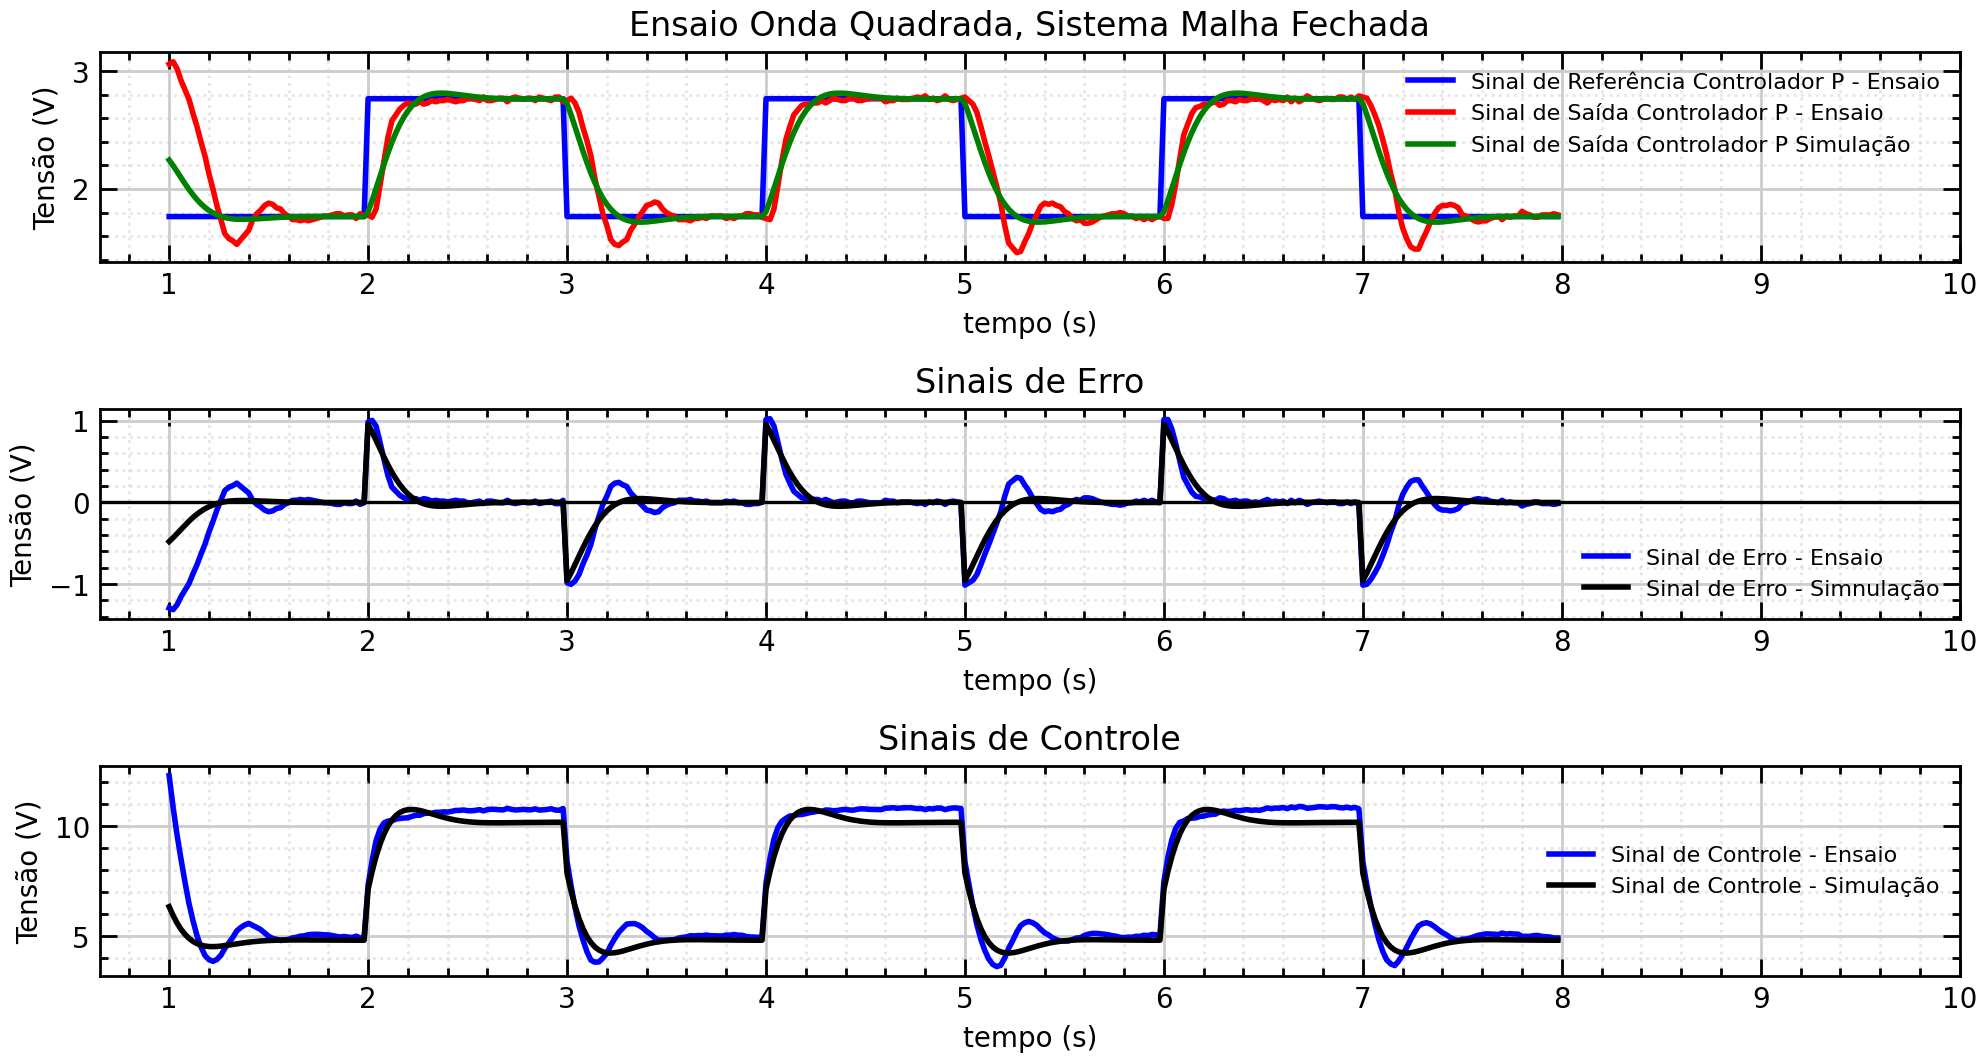

In [65]:
Ts = 0.02
print('\n','Periodo de Amostragem:', Ts)

plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(tempo_controle_pi[50:], referencia_offeset_controlador_pi[50:],
         c='b', label="Sinal de Referência Controlador P - Ensaio")
plt.plot(tempo_controle_pi[50:], sinal_saida_controlador_pi[50:],
         c='r', label= "Sinal de Saída Controlador P - Ensaio")
plt.plot(tempo_controle_pi[50:], y_malha_fechada_pi[50:] + 2.266,
         c='g', label="Sinal de Saída Controlador P Simulação")
plt. title('Ensaio Onda Quadrada, Sistema Malha Fechada', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8)
plt.xticks(range(1, 11))
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.subplot(312)
erro_ensaio_pi = referencia_controlador_pi[50:] - (sinal_saida_controlador_pi[50:] - 2.266)
erro_simu_pi = referencia_controlador_pi[50:] - (y_malha_fechada_pi[50:])
plt.plot(tempo_controle_pi[50:], erro_ensaio_pi,
         c = 'b', label = "Sinal de Erro - Ensaio")
plt.plot(tempo_controle_pi[50:], erro_simu_pi,
         c = 'black', label = "Sinal de Erro - Simnulação")
plt. title('Sinais de Erro', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8, loc='lower right')
plt.axhline(0, color='black', lw=1.2)
plt.xticks(range(1, 11))
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)


plt.subplot(313)
plt.plot(tempo_controle_pi[50:], sinal_controle_controlador_pi[50:] + 7.5,
         c = 'b', label = "Sinal de Controle - Ensaio")
plt.plot(tempo_controle_pi[50:], sinal_controle_pi[50:] + 7.5,
         c = 'black', label = "Sinal de Controle - Simulação")

plt.title('Sinais de Controle', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=8, loc='center right')
plt.xticks(range(1, 11))
plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)


plt.subplots_adjust(hspace=0.7)
plt.show()

O Controlador PI tem por característica zera o erro em regime permanente, pode-se observar esse comportamento nos gráficos acima, os primeiros gráficos são relacionados aos sinais de referência e de saída, tanto para o sistema simulado quanto para a bancada, ao analisar os sinais é possível comcluir que o sinal de saída rastreia o sinal de referência, dessa forma, tornando o erro nulo em regime permanente, isso se confirma ao observar os gráficos centrais, em que mostra os gráficos do erro tanto para o simulado quando para a bancada, em que, o erro em regime é zero.

Por fim, o ultimos gráficos são do sinal de controle, sinulado e da bancada, pode-se constatar que o modelo encontrado se comporta de forma aproximada do modelo real, além disso, foi possível provar o correto funcionamento do controlador projetado.

<br>

---

# Conclusão

Em conclusão, a implementação dos controladores proporcional e proporcional integral foi bem-sucedida. A comparação entre o sistema real e o sistema simulado revelou respostas aproximadamente idênticas, o que indica uma boa correspondência entre a teoria e a prática. Os controladores demonstraram comportar-se conforme o esperado, evidenciando o correto funcionamento dessas técnicas de controle.

Esses resultados validam a eficácia dos controladores proporcional e proporcional integral no sistema em questão. A resposta semelhante entre o sistema real e o sistema simulado indica que os controladores foram capazes de regular o sistema de forma precisa e adequada. Essa concordância entre os resultados reforça a confiabilidade e a aplicabilidade dessas estratégias de controle.

Portanto, a implementação bem-sucedida dos controladores proporcional e proporcional integral, juntamente com a validação dos resultados obtidos, ressalta a importância dessas técnicas no controle de sistemas e reforça seu potencial para alcançar os objetivos desejados.